# Quality Assessment Gene Expression Legionella Infection

In [1]:
import pandas
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True)
%matplotlib inline

### Load Data Frame

(41424, 25)


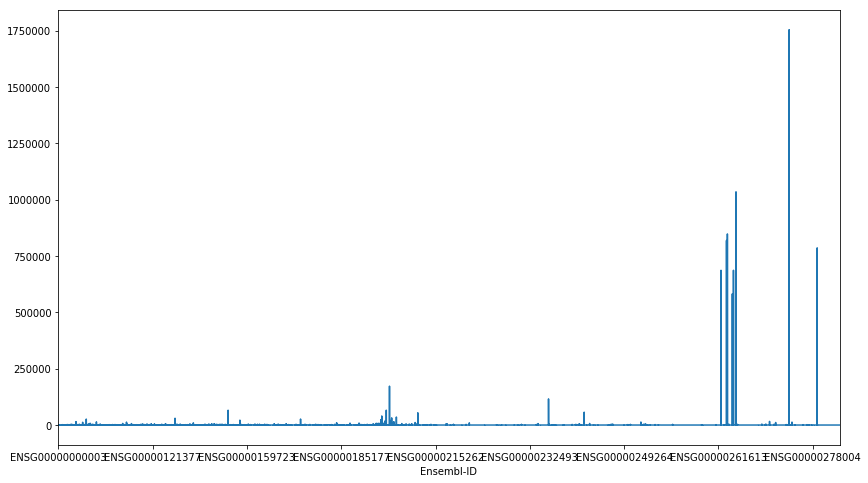

In [2]:
gene_expression = pandas.DataFrame.from_csv('normalized-counts-labels.csv',
                                            encoding='utf-8', sep=',')
ge_nonames = gene_expression.drop('Name', axis=1)
fig = plt.figure(figsize=(14, 8))
ge_nonames.mean(axis=1).plot()
print (gene_expression.shape)

### Preprocessing: Kick out genes whose expression is unrealistically high

In [3]:
threshold = ge_nonames.mean(axis=1).std()*10.
print ("Threshold Gene Expression: {}".format(threshold))
anomalies = gene_expression[ge_nonames.mean(axis=1) > threshold]
ge_anomalies_removed = ge_nonames.drop(anomalies.index)
ge_anomalies_removed.shape

Threshold Gene Expression: 134645.32488240593


(41415, 24)

### Preprocessing: Remove genes with many zeros

(26394, 24)

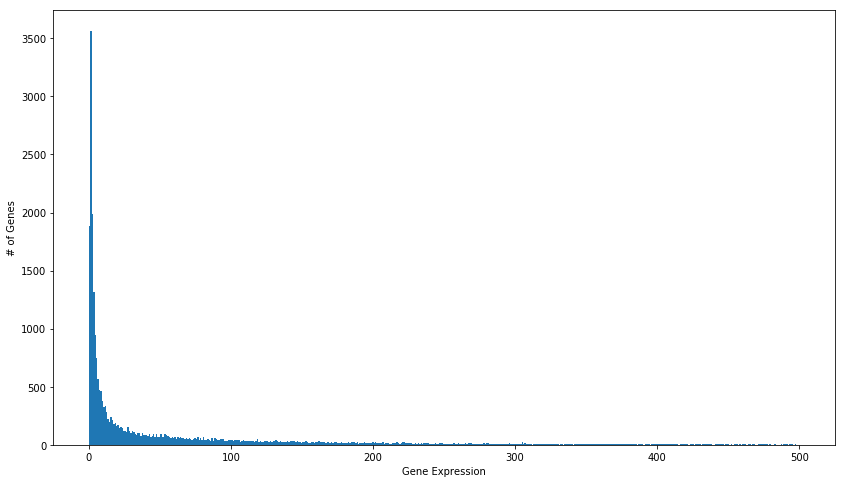

In [4]:
MAX_ZEROS_ALLOWED = .5
ge_zeros_removed = ge_anomalies_removed[ge_anomalies_removed.astype('bool').mean(axis=1)>=(1-MAX_ZEROS_ALLOWED)]
#ge_zeros_removed = ge_nonames[ge_nonames.astype('bool').mean(axis=1)>=(1-MAX_ZEROS_ALLOWED)]
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(0, 500, 500)
ax = plt.hist(ge_zeros_removed.mean(axis=1), bins=bins)
plt.xlabel('Gene Expression')
plt.ylabel('# of Genes')
ge_zeros_removed.shape

### Preprocessing: Scaling the gene expression over genes

In [5]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaled_features = scaler.fit_transform(ge_zeros_removed)
ge_scaled = pandas.DataFrame(scaled_features,
                             index=ge_zeros_removed.index,
                             columns=ge_zeros_removed.columns)
ge_scaled.shape

(26394, 24)

### Preprocessing: Remove low variance genes

Gene with lowest variance which is still included: 1729.1134086316786
5278 genes in data frame


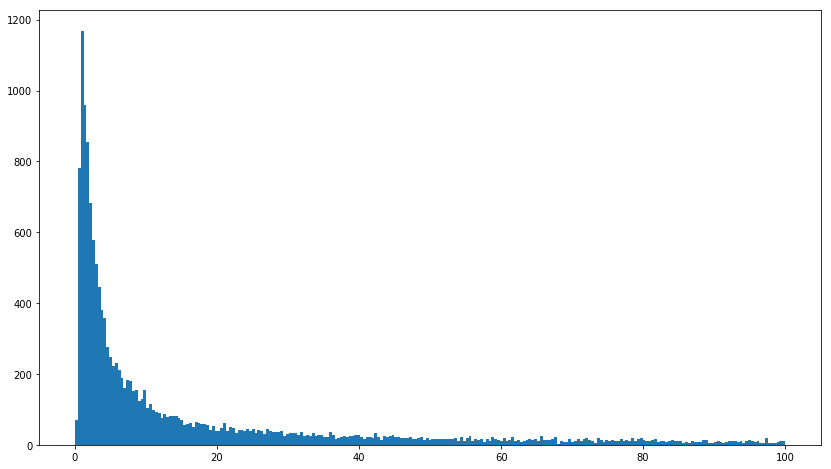

In [6]:
VARIANCE_THRESHOLD_PERCENT = 20.
var_genes = ge_zeros_removed.var(axis=1)
threshold_percent = int((var_genes.shape[0] / 100.)*VARIANCE_THRESHOLD_PERCENT)
highest_n_percent_var = var_genes.sort_values(ascending=False)[:threshold_percent]
ge_high_var = ge_scaled.loc[highest_n_percent_var.index]

print ("Gene with lowest variance which is still included: {}".format(highest_n_percent_var[-1]))
print ("{} genes in data frame".format(ge_high_var.shape[0]))
fig = plt.figure(figsize=(14, 8))
bins = np.linspace(0, 100, 250)
h = plt.hist(var_genes, bins)

# PCA of experiment type

In [7]:
pca2 = PCA(n_components=10)
pca_per_class = pca2.fit_transform(ge_high_var.transpose())
pca_per_class.shape

(24, 10)

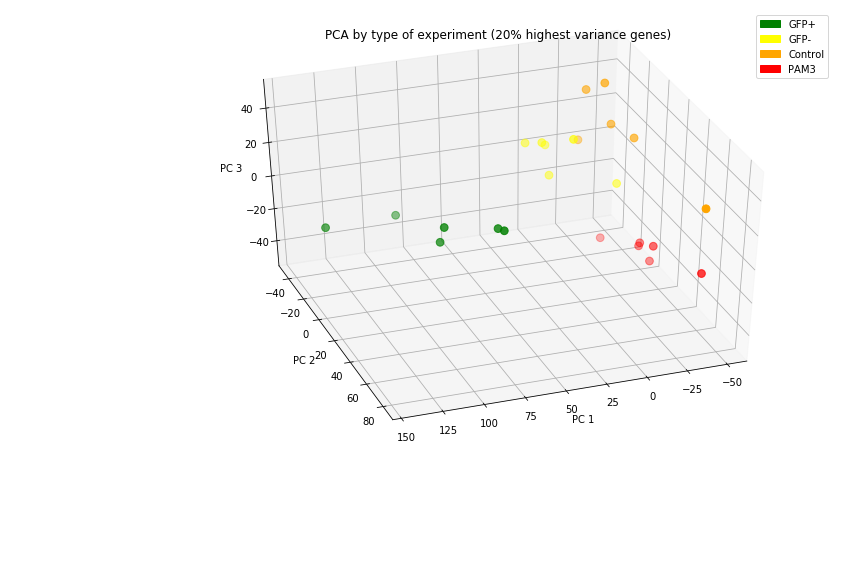

In [8]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
%matplotlib inline
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
# get colors for labels
colors = []
labels = []
for names in ge_nonames.transpose().index:
    if names.startswith('Control'):
        colors.append('orange')
        labels.append('Control')
    elif names.startswith('gfpp'):
        colors.append('green')
        labels.append('GFP+')
    elif names.startswith('gfpm'):
        colors.append('yellow')
        labels.append('GFP-')
    elif names.startswith('Pam'):
        colors.append('red')
        labels.append('Replicates')
    else:
        print ('Group {} not recognized'.format(names))

ax.scatter(pca_per_class[:, 0], pca_per_class[:, 1], pca_per_class[:, 2],
           c=colors, label=labels, s=60)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.title('PCA by type of experiment (20% highest variance genes)')

# legend
gfpp_patch = mpatches.Patch(color='green', label='GFP+')
gfpm_patch = mpatches.Patch(color='yellow', label='GFP-')
control_patch = mpatches.Patch(color='orange', label='Control')
replicate_patch = mpatches.Patch(color='red', label='PAM3')
plt.legend(handles=[gfpp_patch, gfpm_patch, control_patch, replicate_patch])

# annotate names
count = 0
for names in ge_nonames.transpose().index:
    plt.annotate(names, (pca_per_class[count, 0], pca_per_class[count, 1]))
    count += 1

ax.view_init(elev=40, azim=70)

fig.savefig('pca_by_types.svg')

## Explained Variance

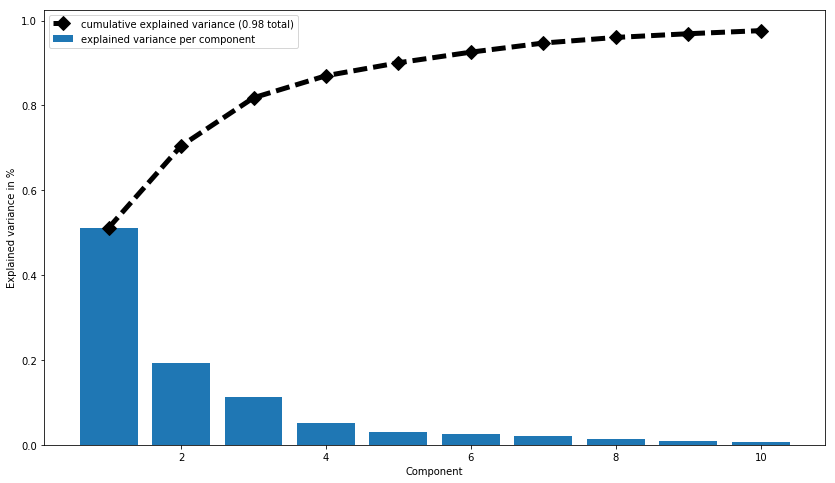

In [9]:
%matplotlib inline
fig = plt.figure(figsize=(14, 8))
x_vals = np.arange(1, pca2.n_components+1)
plt.bar(x_vals, pca2.explained_variance_ratio_, label='explained variance per component')
plt.plot(x_vals,
         [pca2.explained_variance_ratio_[:i+1].sum() for i in range(pca2.n_components)],
         color='black',
         lw=5,
         ls='--',
         marker='D',
         markersize=10,
         label='cumulative explained variance ({:.2f} total)'.format(pca2.explained_variance_ratio_.sum())
        )
plt.ylabel('Explained variance in %')
plt.xlabel('Component')
leg = plt.legend()
fig.savefig('explained_variance.png', dpi=150)

## Get Loadings per Experiment Type

Component 0
-----------
Validated Gene BCL10 is not among 20.0% highest varying genes
Validated Gene SOD2 is not among 20.0% highest varying genes
Validated Gene LINC00346 is not among 20.0% highest varying genes
Validated Gene IL1B is not among 20.0% highest varying genes
Validated Gene GAS5 is not among 20.0% highest varying genes

Component 1
-----------
Validated Gene BCL10 is not among 20.0% highest varying genes
Validated Gene SOD2 is not among 20.0% highest varying genes
Validated Gene LINC00346 is not among 20.0% highest varying genes
Validated Gene IL1B is not among 20.0% highest varying genes
Validated Gene GAS5 is not among 20.0% highest varying genes

Component 2
-----------
Validated Gene BCL10 is not among 20.0% highest varying genes
Validated Gene SOD2 is not among 20.0% highest varying genes
Validated Gene LINC00346 is not among 20.0% highest varying genes
Validated Gene IL1B is not among 20.0% highest varying genes
Validated Gene GAS5 is not among 20.0% highest varying

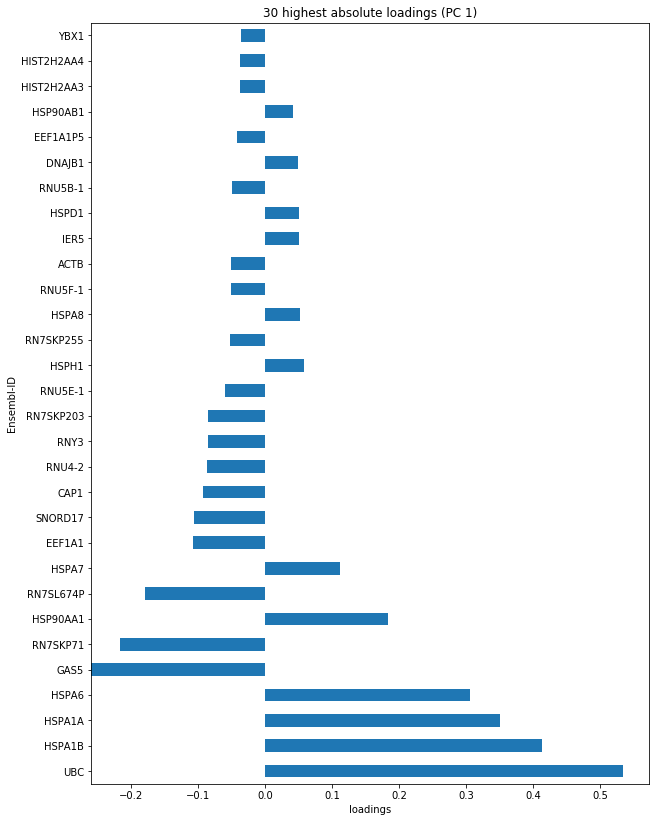

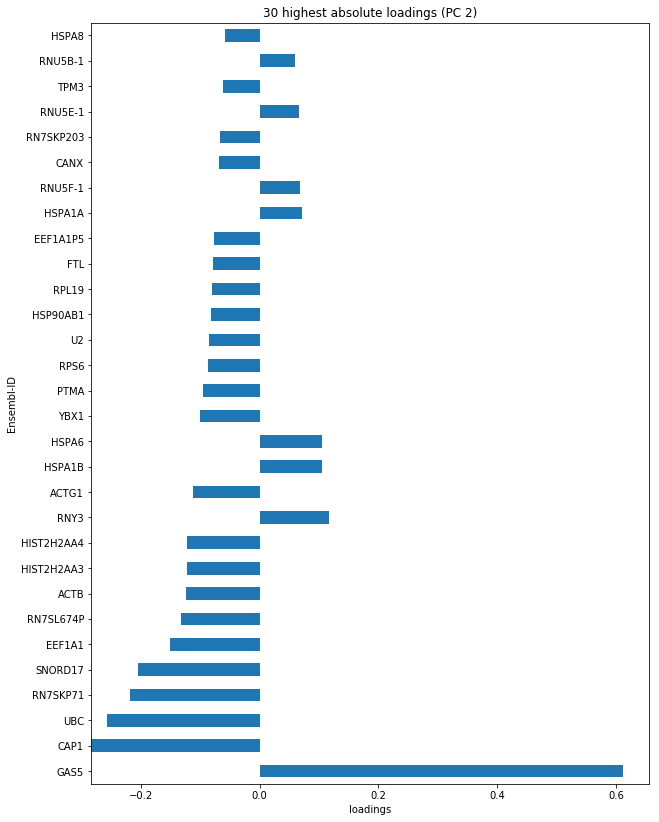

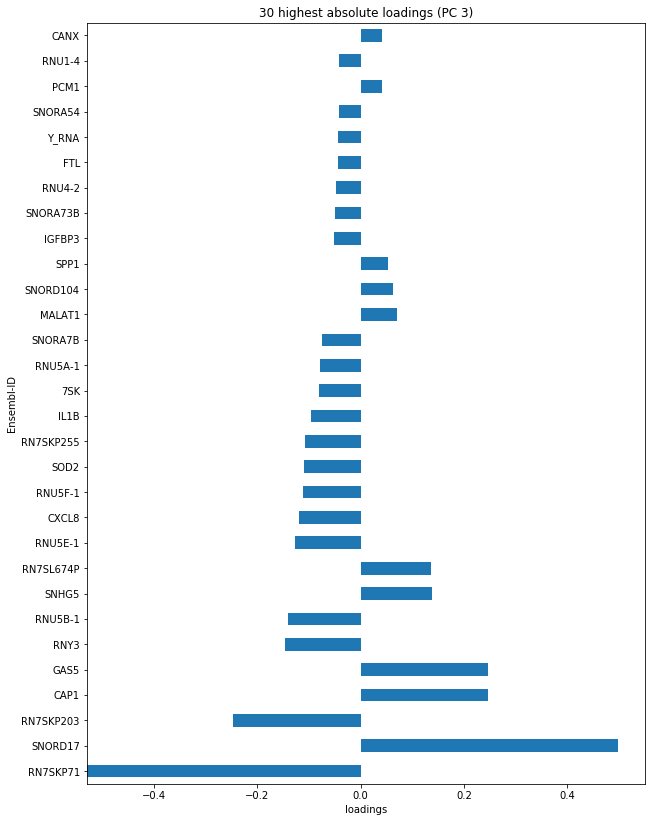

In [18]:
%matplotlib inline
list_of_validated = ['BCL10', 'SOD2', 'LINC00346', 'IL1B', 'GAS5']

for comp in range(3):
    # extract loadings and their names
    loadings = pca2.components_[comp]
    names = gene_expression.loc[ge_high_var.index].Name
    loading_df = pandas.DataFrame(loadings, index=ge_high_var.index, columns=['Loadings'])
    loading_df['Gene_Name'] = pandas.Series(names, index=loading_df.index)
    loading_df['Abs_Loadings'] = loading_df.Loadings.abs()
    loadings_sorted = loading_df.sort_values(by='Abs_Loadings',
                                             ascending=False)
    
    # print some information on loadings for validated genes
    print ("Component {}".format(comp))
    print ("-----------")
    for gene in list_of_validated:
        if gene in loadings_sorted.index:
            idx = loadings_sorted.index.get_loc(gene)
            print ("Validated Gene {} is number {} in contribution to PCA".format(gene, idx))
        else:
            print ("Validated Gene {} is not among {}% highest varying genes".format(gene, VARIANCE_THRESHOLD_PERCENT))
    print()

    # construct loadings plot
    fig = plt.figure(figsize=(10, 14))
    ax = plt.subplot(111)
    top_30_loadings_df = loadings_sorted[:30]
    top_30_loadings_df = top_30_loadings_df.drop('Abs_Loadings', axis=1)
    top_30_loadings_df.plot(kind='barh',
                            legend=False,
                            title='30 highest absolute loadings (PC {})'.format(comp+1),
                            ax=ax
                           )
    ax.set_yticklabels(top_30_loadings_df.Gene_Name)
    ax.set_xlabel('loadings')
    fig.savefig('loadings_pca_{}.svg'.format(comp))
    
    # save loadings to file
    loading_df.to_csv('../../data/preprocessing/loadings_comp_{}.tsv'.format(comp), sep='\t')

In [13]:
comp = 0
loadings = pca2.components_[comp]
names = gene_expression.loc[ge_high_var.index].Name
loading_df = pandas.DataFrame(loadings, index=ge_high_var.index, columns=['Loadings'])
loading_df['Gene_Name'] = pandas.Series(names, index=loading_df.index)
loading_df

,Loadings,Gene_Name
Ensembl-ID,,
ENSG00000234741,-0.260308,GAS5
ENSG00000150991,0.533175,UBC
ENSG00000204388,0.412311,HSPA1B
ENSG00000204389,0.349576,HSPA1A
ENSG00000173110,0.305568,HSPA6
ENSG00000080824,0.182952,HSP90AA1
ENSG00000212232,-0.106603,SNORD17
ENSG00000201428,-0.216631,RN7SKP71
ENSG00000239899,-0.179536,RN7SL674P


# PCA of genes

In [95]:
pca = PCA(n_components=5, whiten=True)
reduced = pca.fit_transform(ge_high_var)
reduced.shape

(2639, 5)

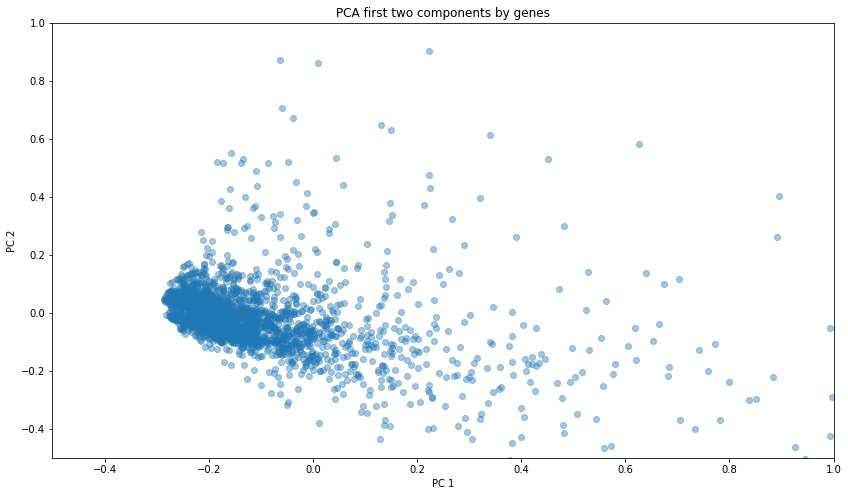

In [96]:
fig = plt.figure(figsize=(14, 8))
plt.scatter(reduced[:, 0], reduced[:, 1], alpha=0.4)
plt.xlim([-.5, 1])
plt.ylim([-.5, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA first two components by genes')

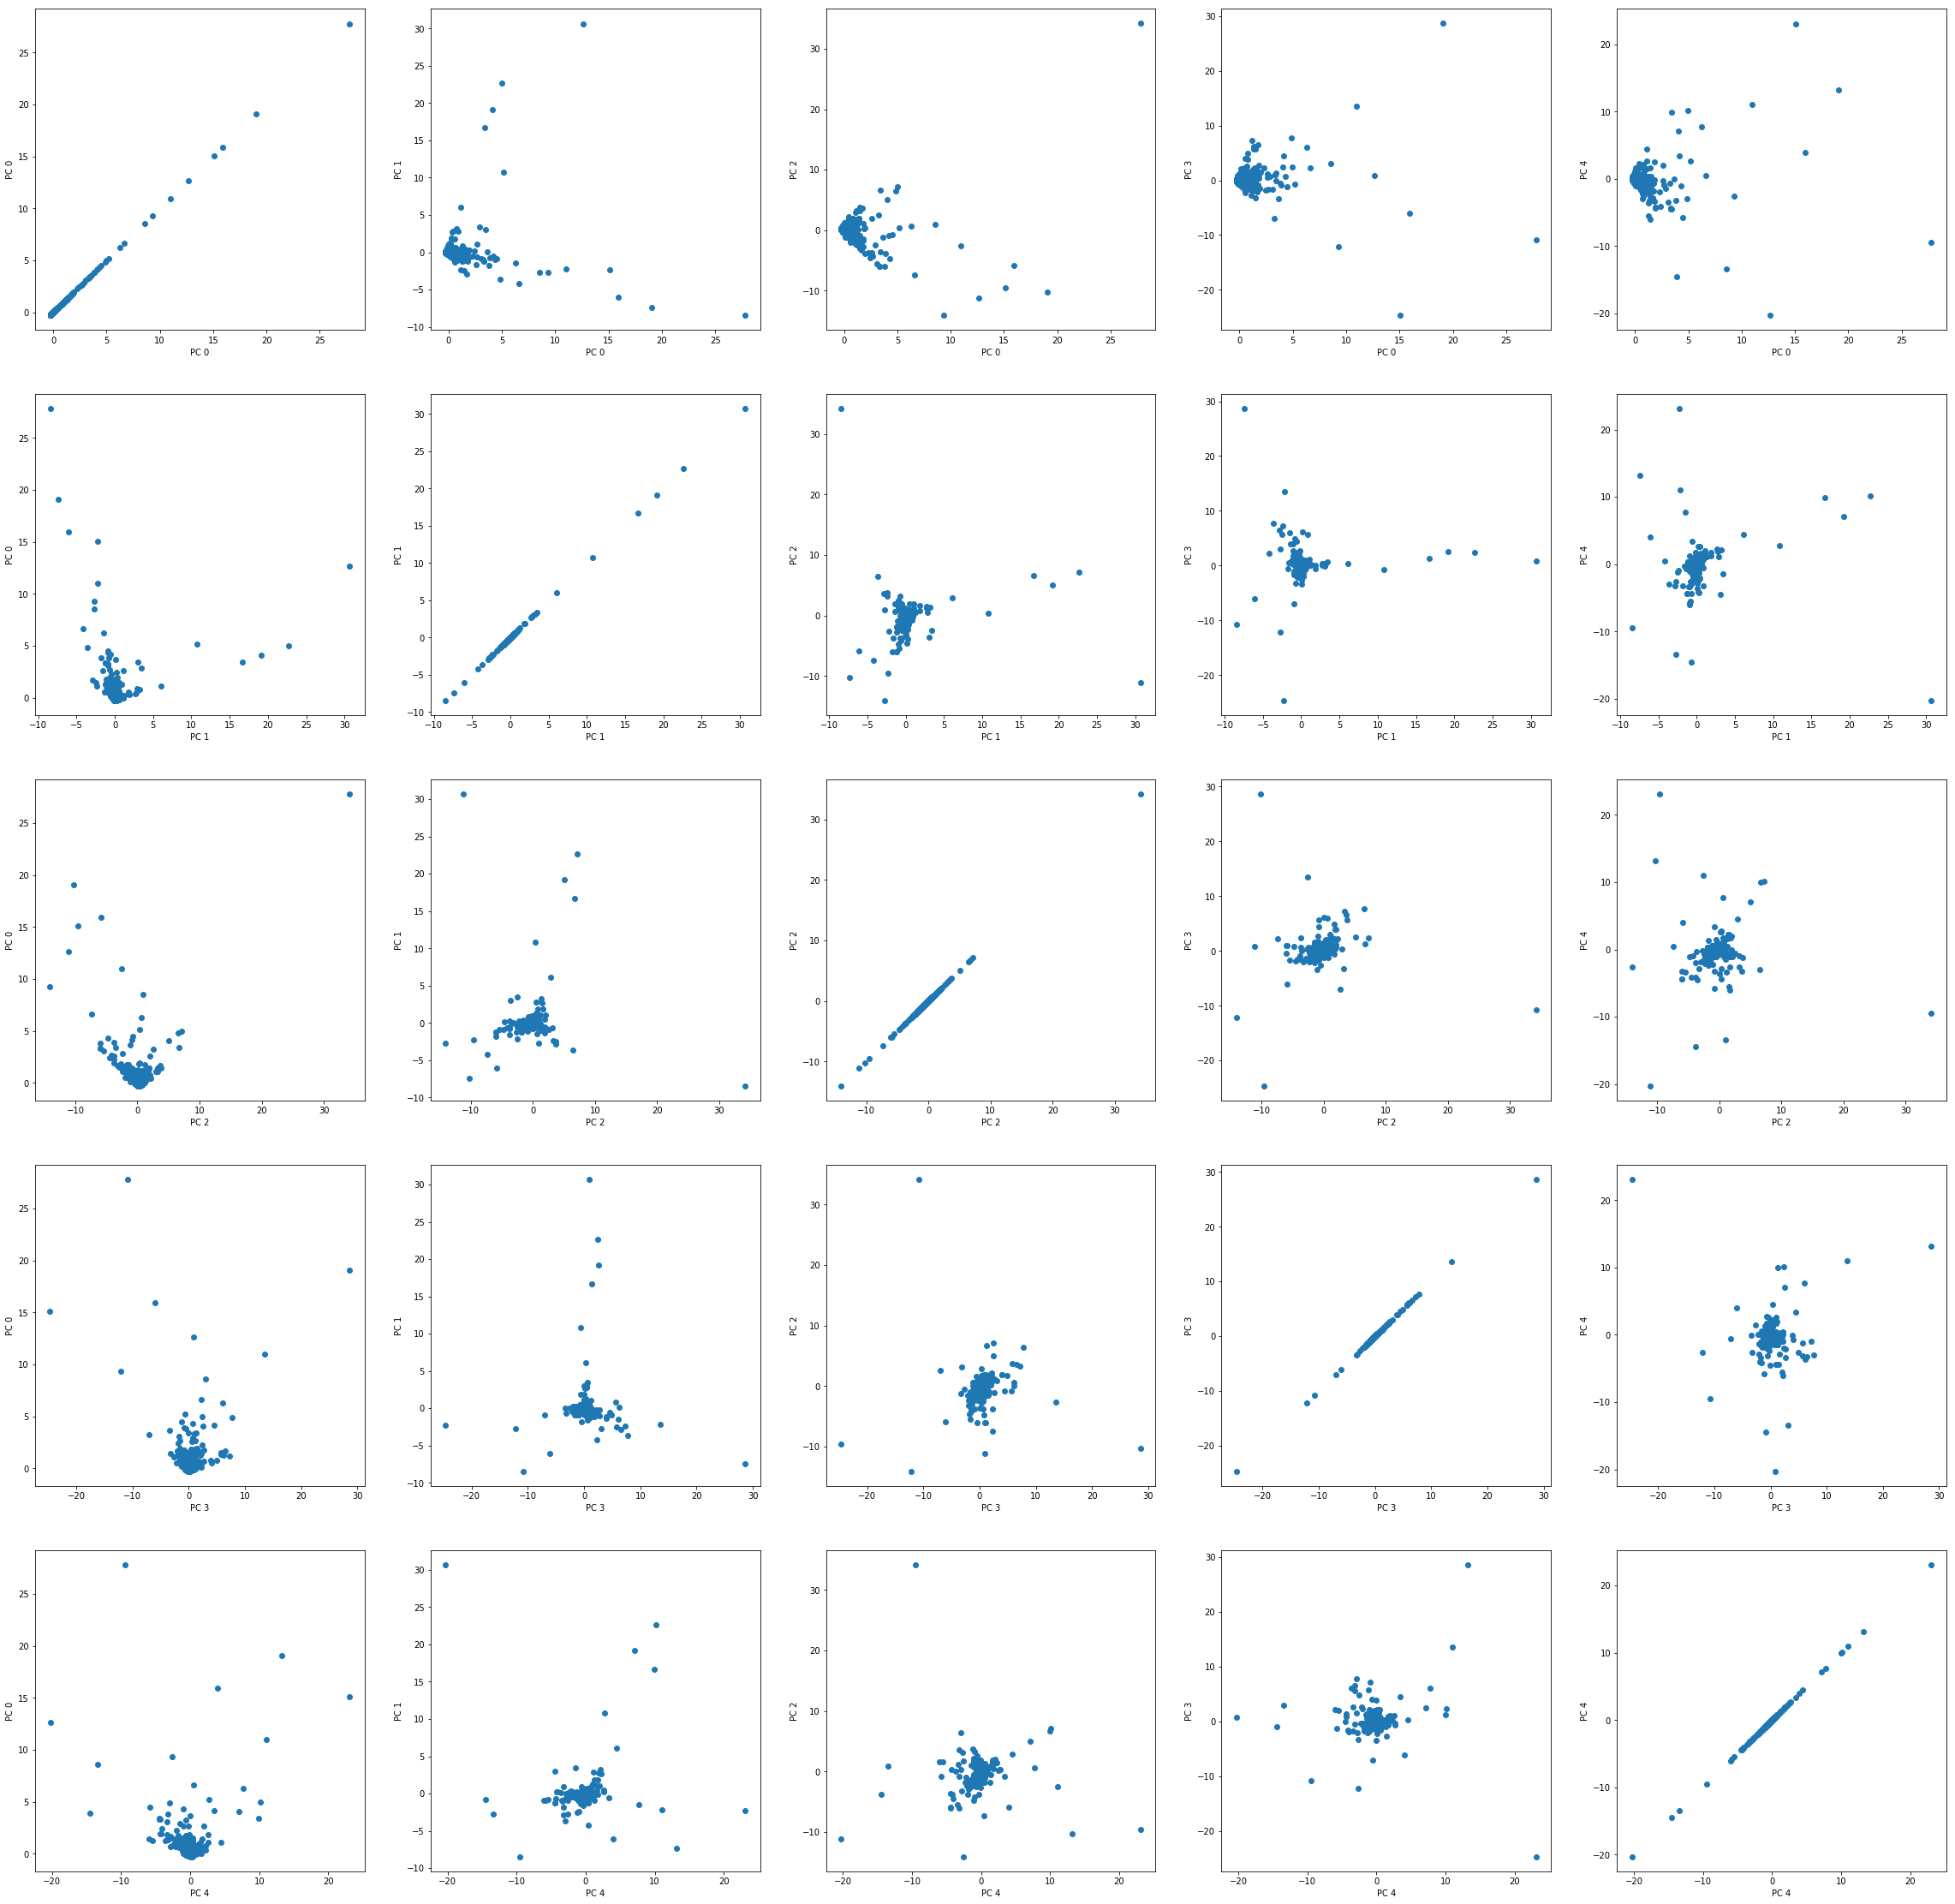

In [97]:
%matplotlib inline
fig = plt.figure(figsize=(40, 40))
count = 1
for x in range(5):
    for y in range(5):
        plt.subplot(5, 5, count)
        plt.scatter(reduced[:, x], reduced[:, y])
        plt.xlabel('PC {}'.format(x))
        plt.ylabel('PC {}'.format(y))
        count += 1

In [192]:
gene_expression[gene_expression.Name == 'GAS5']

,Name,Pam3T16,Pam3T8,Pam3T16.1,Pam3T8.1,Pam3T16.2,Pam3T8.2,ControlT8,ControlT16,ControlT8.1,...,gfpmT8.1,gfpmT16.1,gfpmT8.2,gfpmT16.2,gfppT8,gfppT16,gfppT8.1,gfppT16.1,gfppT8.2,gfppT16.2
Ensembl-ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000234741,GAS5,82177.292729,102110.63566,291816.606367,54346.179454,75099.270684,113793.408882,73451.254057,53562.279514,42532.464604,...,70494.648778,48495.011286,100495.370539,87642.928623,226551.276046,129510.908056,45935.165549,34696.629162,208285.346201,152144.728844
